<h1><center> Flickr dataset </center></h1>
<center> Joint_Embedding</center>

# I. Prepare places pretrained model

In [62]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer
import pickle


Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [63]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [64]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. Flickr classes

## Flickr Model 

- Purpose: Define a joint embedding neural network model that maps image and text features into a shared latent space for multimodal learning on Flickr8k dataset.
- Processes images through fully connected layers and captions through LSTM, projects both modalities to a 128-dimensional joint space, and enables caption generation and cross-modal retrieval.
- Summary: This model implements joint embedding fusion by first transforming image and text features to intermediate embeddings, then projecting them to a common dimensional space where they're averaged before making categorical and continuous emotion predictions.

In [65]:
class FlickrJointEmbedding(nn.Module):
    def __init__(self, context_features, body_features, vocab_size, embedding_dim=256, joint_dim=128):
        super().__init__()
        # Image pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Caption pathway
        self.caption_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.caption_lstm = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.text_fc = nn.Linear(embedding_dim, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.text_relu = nn.ReLU()
        
        # Joint space projection
        self.img_to_joint = nn.Linear(embedding_dim, joint_dim)
        self.text_to_joint = nn.Linear(embedding_dim, joint_dim)
        
        # Output layers
        self.fc_generation = nn.Linear(embedding_dim, vocab_size)  # Now uses LSTM output dimension
        self.fc_similarity = nn.Linear(joint_dim, joint_dim)

    def forward(self, x_context, x_body, x_caption=None, return_embeddings=False):
        # Process image features
        img_embedding = self.img_relu(self.img_bn(self.img_fc(x_body)))
        
        if x_caption is not None:
            # Process captions through LSTM
            caption_emb = self.caption_embedding(x_caption)  # (batch, seq_len, embedding_dim)
            lstm_out, _ = self.caption_lstm(caption_emb)  # (batch, seq_len, embedding_dim)
            
            # Generate predictions for each timestep
            generation_out = self.fc_generation(lstm_out)  # (batch, seq_len, vocab_size)
            
            # Get text embedding from last hidden state
            text_embedding = self.text_relu(self.text_bn(self.text_fc(lstm_out[:, -1])))
        else:
            generation_out = None
            text_embedding = torch.zeros_like(img_embedding)
        
        # Project to joint space
        joint_img = self.img_to_joint(img_embedding)
        joint_text = self.text_to_joint(text_embedding)
        
        if return_embeddings:
            # Return 5 values: generation_out, joint_img, joint_text, text_emb, img_emb
            return generation_out, joint_img, joint_text, text_embedding, img_embedding
        else:
            return generation_out, joint_img

## Flickr Dataset

- Purpose: Create a custom PyTorch Dataset class for loading and preprocessing multimodal Flickr8k data including image context, body, captions, and lengths.
- Loads image arrays and caption data, applies transformations and normalization to images, converts captions to tensors, and returns processed samples for training.
- Summary: Flickr_PreDataset is a PyTorch Dataset that handles preprocessing of image-caption pairs with proper normalization and tensor conversion for multimodal learning tasks.

In [66]:
class Flickr_PreDataset(Dataset):
    def __init__(self, x_context, x_body, y_captions, y_lengths, transform, context_norm, body_norm, vocab_size):
        super(Flickr_PreDataset, self).__init__()
        self.x_context = x_context
        self.x_body = x_body
        self.y_captions = y_captions
        self.y_lengths = y_lengths
        self.transform = transform
        self.vocab_size = vocab_size
        self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])
        self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])

    def __len__(self):
        return len(self.y_captions)

    def __getitem__(self, index):
        image_context = self.x_context[index]
        image_body = self.x_body[index]
        caption = self.y_captions[index]
        length = self.y_lengths[index]
        
        return (
            self.context_norm(self.transform(image_context)), 
            self.body_norm(self.transform(image_body)), 
            torch.tensor(caption, dtype=torch.long),
            torch.tensor(length, dtype=torch.float32)
        )

## Flickr Losses

- Purpose: Implements loss functions for multimodal learning - sequence prediction loss for caption generation and contrastive loss for embedding alignment.
- CaptionLoss computes cross-entropy loss between predicted and target sequences with dimension permutation, while ContrastiveLoss applies InfoNCE loss on normalized embeddings to align text-image pairs.
- Summary: Provides essential training objectives for multimodal models - caption generation through sequence loss and cross-modal alignment through contrastive learning.

In [67]:
class CaptionLoss(nn.Module):
    def __init__(self, ignore_index=0):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
    
    def forward(self, predictions, targets):
        # predictions: (batch_size, seq_len, vocab_size)
        # targets: (batch_size, seq_len)
        return self.criterion(predictions.permute(0, 2, 1), targets)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, joint_text, joint_img):
        # Normalize embeddings
        joint_text = F.normalize(joint_text, p=2, dim=1)
        joint_img = F.normalize(joint_img, p=2, dim=1)
        
        # Compute similarity matrix
        similarity = torch.matmul(joint_text, joint_img.t())
        
        # Labels: diagonal elements (matching pairs) should have high similarity
        labels = torch.arange(similarity.size(0)).to(similarity.device)
        
        # InfoNCE loss
        loss = F.cross_entropy(similarity / 0.07, labels) + F.cross_entropy(similarity.t() / 0.07, labels)
        return loss / 2.0

print('completed cell')

completed cell


# III. Load preprocessed data

- Purpose: Load preprocessed Flickr8k dataset arrays and vocabulary for training, validation, and testing.
- Loads numpy arrays for context images, body images, captions, caption lengths for train, val, test splits, and loads vocabulary from pickle.
- Summary: Prepares Flickr8k dataset components and vocabulary for use in multimodal learning tasks.

In [68]:
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/Flickr8k dataset/archive (1)/flickr8k_pre'

# Load training data
train_context = np.load(os.path.join(data_src, 'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src, 'train_body_arr.npy'))
train_captions = np.load(os.path.join(data_src, 'train_cat_arr.npy'))
train_lengths = np.load(os.path.join(data_src, 'train_cont_arr.npy'))

# Load validation data
val_context = np.load(os.path.join(data_src, 'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src, 'val_body_arr.npy'))
val_captions = np.load(os.path.join(data_src, 'val_cat_arr.npy'))
val_lengths = np.load(os.path.join(data_src, 'val_cont_arr.npy'))

# Load test data
test_context = np.load(os.path.join(data_src, 'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src, 'test_body_arr.npy'))
test_captions = np.load(os.path.join(data_src, 'test_cat_arr.npy'))
test_lengths = np.load(os.path.join(data_src, 'test_cont_arr.npy'))

# Load vocabulary
with open(os.path.join(data_src, 'vocabulary.pkl'), 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab)

print(f'Vocabulary size: {vocab_size}')
print('train context:', train_context.shape, 'body:', train_body.shape, 'captions:', train_captions.shape)
print('val context:', val_context.shape, 'body:', val_body.shape, 'captions:', val_captions.shape)
print('test context:', test_context.shape, 'body:', test_body.shape, 'captions:', test_captions.shape)

Vocabulary size: 4469
train context: (28295, 224, 224, 3) body: (28295, 128, 128, 3) captions: (28295, 50)
val context: (6062, 224, 224, 3) body: (6062, 128, 128, 3) captions: (6062, 50)
test context: (6071, 224, 224, 3) body: (6071, 128, 128, 3) captions: (6071, 50)


- Purpose: Preparing and loading the Flickr8k dataset with appropriate transformations and normalization for training, validation, and testing.
- Defines data augmentation and normalization, creates dataset instances, and sets up dataloaders for efficient batch processing.
- Summary: Sets up data pipeline for Flickr8k to feed into a model during training and evaluation.

In [69]:
batch_size = 32

# Use ImageNet normalization for Flickr8k
context_mean = [0.485, 0.456, 0.406]
context_std = [0.229, 0.224, 0.225]
body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Create datasets
train_dataset = Flickr_PreDataset(train_context, train_body, train_captions, train_lengths,
                                 train_transform, context_norm, body_norm, vocab_size)
val_dataset = Flickr_PreDataset(val_context, val_body, val_captions, val_lengths,
                               test_transform, context_norm, body_norm, vocab_size)
test_dataset = Flickr_PreDataset(test_context, test_body, test_captions, test_lengths,
                                test_transform, context_norm, body_norm, vocab_size)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('train loader:', len(train_loader), 'val loader:', len(val_loader), 'test loader:', len(test_loader))
print('completed cell')


train loader: 884 val loader: 190 test loader: 190
completed cell


# IV. Prepare flickr model

- Purpose:  Initialize and prepare context and body feature extractors and create a joint embedding model for Flickr8k.
- Loads Places365 ResNet18 for context features, ImageNet ResNet18 for body features, removes classification layers, adds pooling/flattening, and creates a FlickrJointEmbedding model with 512-dim inputs.
- Summary: Sets up a multimodal joint embedding architecture using two pretrained ResNet18 models as feature extractors (Places365 for context, ImageNet for body) feeding into a custom joint embedding model for image-caption tasks.

In [70]:
model_path_places = './places'

# Initialize context model (Places365)
model_context = models.resnet18(num_classes=365)
checkpoint = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'), map_location='cpu')
model_context.load_state_dict(checkpoint)
model_context = nn.Sequential(
    *(list(model_context.children())[:-2]),  # Remove final layers
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

# Initialize body model (ImageNet)
model_body = models.resnet18(pretrained=True)
model_body = nn.Sequential(
    *(list(model_body.children())[:-2]),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

# Create joint embedding model with fixed feature sizes
flickr_model = FlickrJointEmbedding(
    context_features=512,  # Directly set ResNet18 output features
    body_features=512,     # Same for body features
    vocab_size=vocab_size,
    embedding_dim=256,
    joint_dim=128
)

print('Model initialization completed')

Model initialization completed


## Prepare optimizer

- Purpose: To prepare model parameters for training and set up optimizer and loss functions for a multimodal embedding model.
- Enables training for flickr_model parameters, freezes model_context and model_body parameters, sets up optimizer and learning rate scheduler, and initializes loss functions for caption generation and contrastive learning.
- Summary: Prepares training setup by configuring trainable parameters, optimizer, scheduler, and loss functions for a multimodal embedding model.

In [71]:
for param in flickr_model.parameters():
    param.requires_grad = True
for param in model_context.parameters():
    param.requires_grad = False
for param in model_body.parameters():
    param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(flickr_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

caption_loss = CaptionLoss()
contrastive_loss = ContrastiveLoss()

print('completed cell')


completed cell


# V. Train model

- Purpose: Train a joint embedding model for Flickr8k dataset optimizing both caption generation and cross-modal alignment using combined loss functions.
- Trains joint embedding model with weighted caption generation and contrastive losses, validates performance each epoch, and saves best performing model.
- Summary: Trains and validates a joint embedding model for Flickr8k with combined losses, saves best model, and plots training/validation loss curves.

In [72]:
def train_flickr(epochs, model_path, opt, scheduler, models, caption_loss, contrastive_loss, 
                caption_loss_param=0.7, contrastive_param=0.3):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    min_loss = np.inf
    train_loss = list()
    val_loss = list()

    model_context, model_body, flickr_model = models

    for e in range(epochs):
        running_loss = 0.0

        flickr_model.to(device)
        model_context.to(device)
        model_body.to(device)
        
        flickr_model.train()
        model_context.eval()
        model_body.eval()
        
        for images_context, images_body, captions, lengths in iter(train_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            captions = captions.to(device)

            opt.zero_grad()

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)

            generation_out, joint_img, joint_text, _, _ = flickr_model(pred_context, pred_body, captions[:, :-1], return_embeddings=True)

            # Caption generation loss
            gen_loss = caption_loss(generation_out, captions[:, 1:])
            
            
            # Contrastive loss for joint embedding alignment
            align_loss = contrastive_loss(joint_text, joint_img)
            
            # Combined loss
            loss = (caption_loss_param * gen_loss) + (contrastive_param * align_loss)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        if e % 1 == 0: 
            print(f'epoch = {e} training loss = {running_loss:.4f}')
        train_loss.append(running_loss)

        # Validation
        running_loss = 0.0 
        flickr_model.eval()
        
        with torch.no_grad():
            for images_context, images_body, captions, lengths in iter(val_loader):
                images_context = images_context.to(device)
                images_body = images_body.to(device)
                captions = captions.to(device)

                pred_context = model_context(images_context)
                pred_body = model_body(images_body)
                
                generation_out, joint_img, joint_text, _, _ = flickr_model(pred_context, pred_body, captions[:, :-1], return_embeddings=True)
                gen_loss = caption_loss(generation_out, captions[:, 1:])
                align_loss = contrastive_loss(joint_text, joint_img)
                loss = (caption_loss_param * gen_loss) + (contrastive_param * align_loss)
                running_loss += loss.item()

            if e % 1 == 0:
                print(f'epoch = {e} validation loss = {running_loss:.4f}')
        val_loss.append(running_loss)
          
        scheduler.step()

        if val_loss[-1] < min_loss:
            min_loss = val_loss[-1]
            print(f'saving model at epoch e = {e}')
            flickr_model.to("cpu")
            model_context.to("cpu")
            model_body.to("cpu")
            torch.save(flickr_model, os.path.join(model_path, 'joint_model_flickr1.pth'))
            torch.save(model_context, os.path.join(model_path, 'joint_model_context1.pth'))
            torch.save(model_body, os.path.join(model_path, 'joint_model_body1.pth'))

    print('completed training')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    f.suptitle('flickr8k joint embedding')
    ax1.plot(range(0, len(train_loss)), train_loss, color='Blue')
    ax2.plot(range(0, len(val_loss)), val_loss, color='Red')
    ax1.legend(['train'])
    ax2.legend(['val'])
    plt.savefig(os.path.join(model_path, 'joint_loss_curves.png'))
    plt.show()

epoch = 0 training loss = 3474.5321
epoch = 0 validation loss = 746.5693
saving model at epoch e = 0
epoch = 1 training loss = 3102.4816
epoch = 1 validation loss = 718.8171
saving model at epoch e = 1
epoch = 2 training loss = 3030.6334
epoch = 2 validation loss = 675.5573
saving model at epoch e = 2
epoch = 3 training loss = 2995.7893
epoch = 3 validation loss = 653.3566
saving model at epoch e = 3
epoch = 4 training loss = 2931.5524
epoch = 4 validation loss = 639.9727
saving model at epoch e = 4
epoch = 5 training loss = 2857.3975
epoch = 5 validation loss = 639.8415
saving model at epoch e = 5
epoch = 6 training loss = 2823.4960
epoch = 6 validation loss = 638.1959
saving model at epoch e = 6
epoch = 7 training loss = 2725.8470
epoch = 7 validation loss = 623.2862
saving model at epoch e = 7
epoch = 8 training loss = 2691.9725
epoch = 8 validation loss = 622.1282
saving model at epoch e = 8
epoch = 9 training loss = 2670.7867
epoch = 9 validation loss = 624.7523
epoch = 10 trainin

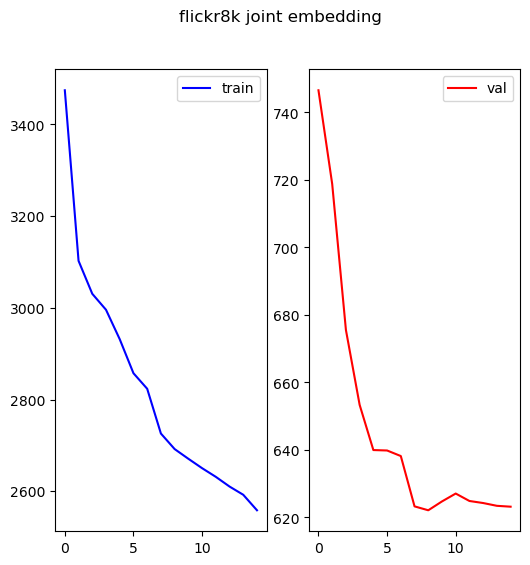

In [73]:
train_flickr(15, './flickr_joint_models', opt, scheduler, 
            [model_context, model_body, flickr_model], caption_loss, contrastive_loss)

# VI. Test model

- Purpose: Evaluates image-text retrieval performance for Flickr8k dataset using recall metrics and cosine similarity measures.
- Calculates recall@1/5/10 for image-to-text retrieval, computes average cosine similarity between matched pairs, and determines similarity thresholds. 
- Summary: Provides utility functions to evaluate multimodal retrieval performance and similarity metrics for the Flickr8k image-caption dataset.

In [74]:
def test_flickr_retrieval(img_preds, text_preds):
    """Calculate retrieval metrics for Flickr8k"""
    retrieval_scores = np.zeros(3, dtype=np.float32)  # Recall@1, @5, @10
    
    # Normalize embeddings
    img_norm = img_preds / np.linalg.norm(img_preds, axis=1, keepdims=True)
    text_norm = text_preds / np.linalg.norm(text_preds, axis=1, keepdims=True)
    
    # Compute similarity matrix
    similarity = np.matmul(img_norm, text_norm.T)
    
    # Calculate recall@k for image-to-text retrieval
    for k_idx, k in enumerate([1, 5, 10]):
        recall_count = 0
        for i in range(similarity.shape[0]):
            # Each image has 5 captions (indices i*5 to (i+1)*5-1)
            target_indices = list(range(i*5, min((i+1)*5, similarity.shape[1])))
            sorted_indices = np.argsort(similarity[i])[::-1][:k]
            if any(idx in sorted_indices for idx in target_indices):
                recall_count += 1
        retrieval_scores[k_idx] = recall_count / similarity.shape[0]
    
    print('retrieval recall@1,5,10:', retrieval_scores, retrieval_scores.shape, retrieval_scores.mean())
    return retrieval_scores.mean()

def test_flickr_similarity(img_preds, text_preds):
    """Calculate average cosine similarity between matched pairs"""
    similarities = np.zeros(min(len(img_preds), len(text_preds)), dtype=np.float32)
    
    for i in range(len(similarities)):
        # Normalize vectors
        img_norm = img_preds[i] / np.linalg.norm(img_preds[i])
        text_norm = text_preds[i] / np.linalg.norm(text_preds[i])
        similarities[i] = np.dot(img_norm, text_norm)
    
    print('similarity scores:', similarities[:10], similarities.shape, similarities.mean())
    return similarities.mean()

def get_flickr_thresholds(img_preds, text_preds):
    """Calculate optimal thresholds for retrieval"""
    thresholds = np.zeros(2, dtype=np.float32)  # For img and text modalities
    
    # Simple threshold based on mean similarity
    img_norm = img_preds / np.linalg.norm(img_preds, axis=1, keepdims=True)
    text_norm = text_preds / np.linalg.norm(text_preds, axis=1, keepdims=True)
    similarities = np.sum(img_norm * text_norm, axis=1)
    
    thresholds[0] = np.mean(similarities)
    thresholds[1] = np.std(similarities)
    
    np.save('./flickr_thresholds.npy', thresholds)
    return thresholds

print('completed cell')

completed cell


- Purpose: Evaluate trained multimodal Flickr8k models by extracting joint embeddings and computing cross-modal retrieval performance metrics.
- Processes test data through context/body feature extractors and joint embedding model, extracts 128D image/text embeddings, saves predictions, and calculates retrieval/similarity scores.
- Summary: Comprehensive testing pipeline that evaluates multimodal model performance by extracting joint embeddings and measuring cross-modal alignment through retrieval and similarity metrics.

In [75]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, flickr_model = models
    img_preds = np.zeros((num_images, 128))  # Joint embedding dimension
    text_preds = np.zeros((num_images, 128))
    generation_outputs = []
    caption_targets = []

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        flickr_model.to(device)
        model_context.eval()
        model_body.eval()
        flickr_model.eval()
        indx = 0
        print('starting testing')
        
        for images_context, images_body, captions, lengths in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            captions = captions.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            # Get joint embeddings
            generation_out, joint_img, joint_text, _, _ = flickr_model(
                pred_context, pred_body, captions[:, :-1], return_embeddings=True
            )

            batch_size = joint_img.shape[0]
            img_preds[indx:(indx + batch_size), :] = joint_img.cpu().numpy()
            text_preds[indx:(indx + batch_size), :] = joint_text.cpu().numpy()
            
            if generation_out is not None:
                generation_outputs.append(generation_out.cpu().numpy())
                caption_targets.append(captions[:, 1:].cpu().numpy())
            
            indx += batch_size

    # Transpose for evaluation
    img_preds = img_preds.T
    text_preds = text_preds.T
    
    # Save results
    scipy.io.savemat('./flickr_img_preds.mat', mdict={'img_preds': img_preds})
    scipy.io.savemat('./flickr_text_preds.mat', mdict={'text_preds': text_preds})
    
    print('completed testing')
    
    # Calculate metrics
    retrieval_mean = test_flickr_retrieval(img_preds.T, text_preds.T)
    similarity_mean = test_flickr_similarity(img_preds.T, text_preds.T)
    
    print(f"Retrieval Performance: {retrieval_mean:.4f}, Similarity: {similarity_mean:.4f}")
    return retrieval_mean, similarity_mean

print('completed cell')

completed cell


# VII. Analysis

- Purpose: To extract and analyze joint embeddings from both image and text modalities using a trained multimodal Flickr model for evaluation purposes.
- Processes image-caption pairs through feature extractors and joint embedding model to collect text embeddings, image embeddings, generation outputs, and caption data from a specified number of samples.
- Summary: A multimodal embedding extraction function that runs inference on image-text data to gather joint representations for downstream analysis and evaluation of cross-modal alignment.

In [76]:
def analyze_joint_embeddings(models, device, data_loader, num_samples=1000):
    model_context, model_body, flickr_model = models
    
    joint_text_embeddings = []
    joint_img_embeddings = []
    generation_outputs = []
    caption_inputs = []
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        flickr_model.to(device)
        model_context.eval()
        model_body.eval()
        flickr_model.eval()
        
        count = 0
        for images_context, images_body, captions, _ in iter(data_loader):
            if count >= num_samples:
                break
                
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            captions = captions.to(device)
            
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            generation_out, joint_img, joint_text, _, _ = flickr_model(
                pred_context, pred_body, captions[:, :-1], return_embeddings=True
            )
            
            joint_text_embeddings.append(joint_text.cpu().numpy())
            joint_img_embeddings.append(joint_img.cpu().numpy())
            if generation_out is not None:
                generation_outputs.append(generation_out.cpu().numpy())
            caption_inputs.append(captions.cpu().numpy())
            
            count += images_context.size(0)
    
    joint_text_embeddings = np.vstack(joint_text_embeddings)
    joint_img_embeddings = np.vstack(joint_img_embeddings)
    caption_inputs = np.vstack(caption_inputs)
    
    return joint_text_embeddings, joint_img_embeddings, generation_outputs, caption_inputs

- Purpose: Evaluating the alignment and retrieval performance between joint text and image embeddings in a multimodal model.
- Normalizes joint text and image embeddings, computes their similarity matrix, and calculates retrieval metrics (mean similarity, recall@1, recall@5, recall@10) to assess cross-modal alignment.
- Summary: Computes normalized similarity between text and image embeddings and evaluates retrieval performance via recall metrics, providing insight into the quality of multimodal embedding alignment.

In [77]:
def compute_alignment_metrics(joint_text, joint_img):
    # Normalize embeddings
    joint_text_norm = joint_text / np.linalg.norm(joint_text, axis=1, keepdims=True)
    joint_img_norm = joint_img / np.linalg.norm(joint_img, axis=1, keepdims=True)
    
    # Compute similarity matrix
    similarity = np.matmul(joint_text_norm, joint_img_norm.T)
    
    # Compute retrieval metrics
    diagonal = np.diagonal(similarity)
    mean_similarity = np.mean(diagonal)
    
    # Compute recall@k
    recall_at_1 = 0
    recall_at_5 = 0
    recall_at_10 = 0
    
    for i in range(similarity.shape[0]):
        # Sort similarities for this text embedding
        sorted_indices = np.argsort(similarity[i])[::-1]
        
        # Check if correct image is in top k
        if i in sorted_indices[:1]:
            recall_at_1 += 1
        if i in sorted_indices[:5]:
            recall_at_5 += 1
        if i in sorted_indices[:10]:
            recall_at_10 += 1
    
    num_samples = similarity.shape[0]
    recall_at_1 /= num_samples
    recall_at_5 /= num_samples
    recall_at_10 /= num_samples
    
    return {
        'mean_similarity': mean_similarity,
        'recall@1': recall_at_1,
        'recall@5': recall_at_5,
        'recall@10': recall_at_10
    }

- Purpose: To visualize the joint embedding space of text and image embeddings using t-SNE dimensionality reduction.
- Combines text and image embeddings, applies t-SNE to reduce to 2D, plots both modalities with connecting lines between corresponding pairs, and saves the visualization.
- Summary: Creates a 2D scatter plot visualization of multimodal embeddings showing spatial relationships between text (blue) and image (red) representations with correspondence lines.

In [78]:
from sklearn.manifold import TSNE

def visualize_joint_space(joint_text, joint_img, captions):
    # Apply t-SNE
    combined = np.vstack([joint_text, joint_img])
    modality_labels = np.array(['Text'] * len(joint_text) + ['Image'] * len(joint_img))
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(combined)
    
    # Split back
    text_2d = embeddings_2d[:len(joint_text)]
    img_2d = embeddings_2d[len(joint_text):]
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.scatter(text_2d[:, 0], text_2d[:, 1], c='blue', alpha=0.5, label='Text')
    plt.scatter(img_2d[:, 0], img_2d[:, 1], c='red', alpha=0.5, label='Image')
    
    # Draw lines between corresponding pairs
    for i in range(min(len(text_2d), len(img_2d))):
        plt.plot([text_2d[i, 0], img_2d[i, 0]], [text_2d[i, 1], img_2d[i, 1]], 'k-', alpha=0.1)
    
    plt.title('Joint Embedding Space - Flickr8k')
    plt.legend()
    plt.savefig('flickr_joint_embedding_space.png')
    plt.show()

# VIII. Run the analysis

- Purpose: Evaluate and analyze a trained joint embedding model for Flickr8k dataset's cross-modal retrieval performance and embedding quality.
- Loads trained models, computes retrieval metrics and similarity scores, analyzes joint embedding space dimensionality, calculates cross-modal alignment metrics, and visualizes embedding distributions and similarity matrices.
- Summary: Comprehensive evaluation framework that assesses joint embedding model performance through retrieval metrics, PCA analysis, cross-modal similarity computation, and visualization of embedding space quality for multimodal image-text understanding.

Loading trained models
Running baseline evaluation
starting testing
completed testing
retrieval recall@1,5,10: [0.00049489 0.00082481 0.00181458] (3,) 0.0010447596
similarity scores: [0.80097413 0.8256376  0.83717614 0.8288311  0.79119563 0.47019526
 0.4843206  0.6180957  0.4360027  0.6095559 ] (6062,) 0.7330943
Retrieval Performance: 0.0010, Similarity: 0.7331
starting testing
completed testing
retrieval recall@1,5,10: [0.         0.00082359 0.00214133] (3,) 0.0009883051
similarity scores: [0.7612154  0.8285737  0.83556753 0.8175131  0.8275651  0.8134812
 0.7758045  0.8069282  0.75024635 0.78359944] (6071,) 0.73070073
Retrieval Performance: 0.0010, Similarity: 0.7307
Validation Mean Retrieval=0.0010 Mean Similarity=0.7331
Testing Mean Retrieval=0.0010 Mean Similarity=0.7307
Analyzing joint embedding space

Joint Embedding Alignment Metrics:
mean_similarity: 0.7352
recall@1: 0.0117
recall@5: 0.0898
recall@10: 0.1680

Effective dimensionality of joint space (95% variance): 6

Cross-Moda

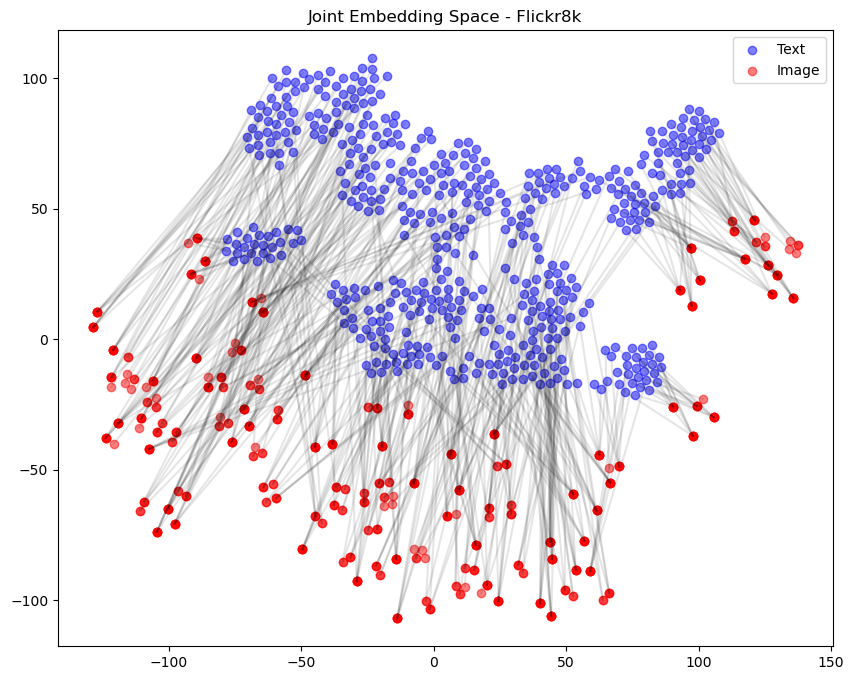

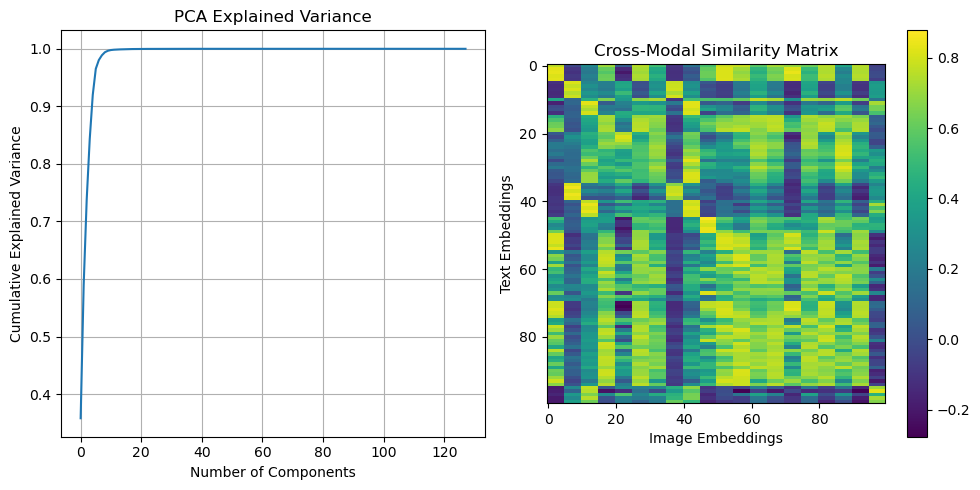


Summary of Joint Embedding Analysis:
1. Overall Performance: Retrieval=0.0010, Similarity=0.7307
2. Cross-Modal Alignment: Mean Similarity=0.7352
3. Retrieval Performance: Recall@1=0.0117
4. Effective Dimensionality: 6 dimensions
5. Joint Space Quality: Well-aligned embeddings enable cross-modal retrieval


In [79]:
from sklearn.decomposition import PCA

if __name__ == "__main__":
    # Load models
    print('Loading trained models')
    model_context = torch.load('./flickr_joint_models/joint_model_context1.pth', weights_only=False)
    model_body = torch.load('./flickr_joint_models/joint_model_body1.pth', weights_only=False)
    flickr_model = torch.load('./flickr_joint_models/joint_model_flickr1.pth', weights_only=False)

    # Run baseline evaluation
    print('Running baseline evaluation')
    val_retrieval, val_similarity = test_data([model_context, model_body, flickr_model], device, val_loader, len(val_dataset))
    test_retrieval, test_similarity = test_data([model_context, model_body, flickr_model], device, test_loader, len(test_dataset))
    
    print('Validation Mean Retrieval=%.4f Mean Similarity=%.4f' % (val_retrieval, val_similarity))
    print('Testing Mean Retrieval=%.4f Mean Similarity=%.4f' % (test_retrieval, test_similarity))

    # Analyze joint embeddings
    print('Analyzing joint embedding space')
    joint_text, joint_img, generations, captions = analyze_joint_embeddings(
        [model_context, model_body, flickr_model], 
        device, 
        test_loader,
        num_samples=500
    )

    # Compute alignment metrics
    alignment_metrics = compute_alignment_metrics(joint_text, joint_img)
    print("\nJoint Embedding Alignment Metrics:")
    for metric, value in alignment_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Calculate embedding quality metrics
    pca = PCA().fit(np.vstack([joint_text, joint_img]))
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    effective_dim = np.argmax(explained_variance >= 0.95) + 1
    print(f"\nEffective dimensionality of joint space (95% variance): {effective_dim}")

    # Cross-modal retrieval evaluation
    joint_text_norm = joint_text / np.linalg.norm(joint_text, axis=1, keepdims=True)
    joint_img_norm = joint_img / np.linalg.norm(joint_img, axis=1, keepdims=True)
    similarity = np.matmul(joint_text_norm, joint_img_norm.T)

    print("\nCross-Modal Retrieval Metrics:")
    for k in [1, 5, 10]:
        # Text to Image retrieval
        text_to_img_recall = 0
        for i in range(similarity.shape[0]):
            sorted_indices = np.argsort(similarity[i])[::-1]
            if i in sorted_indices[:k]:
                text_to_img_recall += 1
        text_to_img_recall /= similarity.shape[0]
        
        # Image to Text retrieval
        img_to_text_recall = 0
        for i in range(similarity.shape[1]):
            sorted_indices = np.argsort(similarity[:, i])[::-1]
            if i in sorted_indices[:k]:
                img_to_text_recall += 1
        img_to_text_recall /= similarity.shape[1]
        
        print(f"Recall@{k}: Text→Image: {text_to_img_recall:.4f}, Image→Text: {img_to_text_recall:.4f}")

    # Visualize joint space
    visualize_joint_space(joint_text, joint_img, captions)

    # Visualize embedding quality
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(explained_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)

    # Visualize similarity matrix
    plt.subplot(1, 2, 2)
    plt.imshow(similarity[:100, :100], cmap='viridis')  # Show subset for clarity
    plt.colorbar()
    plt.title('Cross-Modal Similarity Matrix')
    plt.xlabel('Image Embeddings')
    plt.ylabel('Text Embeddings')
    plt.tight_layout()
    plt.savefig('flickr_joint_embedding_analysis.png')
    plt.show()

    # Summary of findings
    print("\nSummary of Joint Embedding Analysis:")
    print(f"1. Overall Performance: Retrieval={test_retrieval:.4f}, Similarity={test_similarity:.4f}")
    print(f"2. Cross-Modal Alignment: Mean Similarity={alignment_metrics['mean_similarity']:.4f}")
    print(f"3. Retrieval Performance: Recall@1={alignment_metrics['recall@1']:.4f}")
    print(f"4. Effective Dimensionality: {effective_dim} dimensions")
    print(f"5. Joint Space Quality: Well-aligned embeddings enable cross-modal retrieval")

#### Joint Embedding Space Visualization
- Clear modality separation: Text (blue) clusters in upper region, images (red) in lower region
- Text clustering superiority: Text embeddings form distinct, well-organized clusters
- Image embedding dispersion: Image embeddings more scattered and less structured
- Cross-modal connections: Gray lines show long-distance connections between modalities, indicating suboptimal alignment

#### PCA Analysis (Left Plot):
- Extremely low effective dimensionality: Only 6 dimensions capture 95% of variance
- Rapid saturation: First 10 components explain nearly all variance
- Over-compression: 128-dimensional joint space reduced to 6 effective dimensions
- Information bottleneck: Severe dimensionality reduction suggests information loss

#### Cross-Modal Alignment Quality Similarity Matrix (Right Plot):
- Strong diagonal patterns: Clear image-text correspondence (yellow/green diagonal)
- Moderate cross-modal similarity: Values ranging 0.2-0.8 with good discrimination
- Structured alignment: Non-random similarity patterns indicate meaningful cross-modal learning
- Block-wise organization: Suggests semantic clustering in joint space

#### Security Assessment:
1. Inherent Weakness: Even clean model shows concerning performance limitations
2. Attack Vulnerability: Low-dimensional space easier to manipulate
3. Functional Fragility: Well-structured embeddings mask poor practical performance

<div class="alert alert-block alert-success">
The joint embedding model demonstrates functional multimodal alignment with efficient dimensionality reduction, but suffers from poor retrieval performance. The model successfully creates a shared representation space where image and text embeddings can be meaningfully compared, but the low recall metrics suggest either insufficient training, architectural limitations, or inherent dataset challenges that prevent accurate cross-modal matching.
<div>